# Introduction
No work to be done. Just want the section numbers to match.

# Becoming Familiar with the Primer

The intution behind **Stochastic Gradient Descent with Momentum (SGD+)** is that if your previous gradient was pointing a certain direction and your current gradient points in a similar direction, then you should step in some direction of the combination of the two in the parameter space. 

The update equation is 
$$ \delta p_k = \gamma \delta p_{k-1} + \alpha g_k $$
$$ p_{k+1} = p_k - \delta p_k $$

Where gamma is the momentum coefficient, alpha is the learning rate, $g_k$ is the gradient at step k, and $p_k$ is the vector of parameters. $\delta p_k$ gets initialized to 0.


This is still not ideal because some parameters may not need to be updated as much according to a certain training sample since they played little roll in its evaluation and therefore loss. In comes **Adaptive Moment Estimation (Adam)** which tailors the learning rate to each parameter individually according to how large its running average of gradients w.r.t. the parameter has been. The update equations are:
$$ m_k = \beta_1 m_{k-1} + (1 - \beta_1)g_k $$
$$ v_k = \beta_2 v_{k-1} + (1 - \beta_2)(g_k)^2 $$
$$ \hat{m}_k = \frac{m_k}{1-\beta_1^k} $$
$$ \hat{v}_k = \frac{v_k}{1-\beta_2^k} $$
$$ p_k = p_{k-1} - \frac{\alpha}{\sqrt{\hat{v}_k + \eta}} \hat{m}_k $$

The Beta parameters are near equal to one. The eta is some small value to keep from dividing by zero. The hatted versions are added to counter the effects of the moments being close to zero ($m_k$ and $v_k$) for several iterations when being initialized to zero.

In [1]:
import re
import builtins
import matplotlib.pyplot as plt

def collect_loss(call, *args):
    original_print = builtins.print
    loss_data = list()
    plt.ioff()
    
    def new_print(val):
        pattern = r"loss = ([\d\-\.]+)"
        loss = float(re.search(pattern, val)[1])
        loss_data.append(loss)
    
    builtins.print = new_print
    call(*args)
    plt.ion()
    builtins.print = original_print
    return loss_data

def nodisplay(call, *args):
    original_print = builtins.print
    builtins.print = lambda *val: None
    retVal = call(*args)
    builtins.print = original_print
    return retVal
    


In [2]:
import random
import operator
import numpy as np

seed = 0           
random.seed(seed)
np.random.seed(seed)

from ComputationalGraphPrimer import *

class CGP_SGDPlus(ComputationalGraphPrimer):
    def parse_expressions(self):
        super().parse_expressions()
        self._prev_grads = {param: 0 for param in self.learnable_params}
        self._prev_bias = 0
        
    def run_training_loop_one_neuron_model(self, training_data):
        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                


        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_errors, data_tuples, deriv_sigmoids)     ## BACKPROP loss
        # plt.figure()     
        # plt.plot(loss_running_record) 
        # plt.show()   
        
    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid):
        gamma = .9
        
        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars = [x for x in zip(*vals_for_input_vars)]
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        for i,param in enumerate(self.vals_for_learnable_params):
            ## Calculate the next step in the parameter hyperplane
            grad = 0
            input_vals = vals_for_input_vars_dict[param_to_vars_map[param]]
            for k in range(len(y_error)):
                error = y_error[k]
                val = input_vals[k]
                dsig = deriv_sigmoid[k]
                grad += -2 * error * dsig * val
            grad /= float(len(y_error))
                
            newgrad = self.learning_rate * grad
            step = gamma * self._prev_grads[param] + newgrad
            self._prev_grads[param] = step
            ## Update the learnable parameters
            self.vals_for_learnable_params[param] -= step
            # self.vals_for_learnable_params[param] -= self.learning_rate * grad
        
        grad = 0
        for k in range(len(y_error)):
            error = y_error[k]
            dsig = deriv_sigmoid[k]
            grad += -2 * error * dsig
        grad /= float(len(y_error))

        new_bias_grad = self.learning_rate * grad
        bias_step = gamma * self._prev_bias + new_bias_grad
        self._prev_bias = bias_step
        self.bias -= bias_step    ## Update the bias
        # self.bias -= self.learning_rate * grad
    
class CGP_Adam(CGP_SGDPlus):
    def parse_expressions(self):
        super().parse_expressions()
        self._prev_mom1 = {param: 0 for param in self.learnable_params}
        self._prev_mom2 = {param: 0 for param in self.learnable_params}
        self._prev_mom1_bias = 0
        self._prev_mom2_bias = 0
        
        self.eta = 1e-4
        self.beta1 = .9
        self.beta2 = .99
        
        self.beta1_pow = self.beta1
        self.beta2_pow = self.beta2
        
        
    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid):
        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars = [x for x in zip(*vals_for_input_vars)]
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        for i,param in enumerate(self.vals_for_learnable_params):

            grad = 0
            input_vals = vals_for_input_vars_dict[param_to_vars_map[param]]
            for k in range(len(y_error)):
                error = y_error[k]
                val = input_vals[k]
                dsig = deriv_sigmoid[k]
                grad += -2 * error * dsig * val
            grad /= float(len(y_error))
            
            newgrad = grad
            mk = self.beta1 * self._prev_mom1[param] + (1 - self.beta1) * newgrad
            self._prev_mom1[param] = mk
            
            vk = self.beta2 * self._prev_mom2[param] + (1 - self.beta2) * (newgrad**2)
            self._prev_mom2[param] = vk
            
            cor_mk = mk / (1 - self.beta1_pow)
            cor_vk = vk / (1 - self.beta2_pow)
            
            step = self.learning_rate / np.sqrt(cor_vk + self.eta) * cor_mk
            
            self.vals_for_learnable_params[param] -= step
            
        grad = 0
        for k in range(len(y_error)):
            error = y_error[k]
            dsig = deriv_sigmoid[k]
            grad += -2 * error * dsig
        grad /= float(len(y_error))
        
        new_bias_grad = grad
        mk = self.beta1 * self._prev_mom1_bias + (1 - self.beta1) * new_bias_grad
        self._prev_mom1_bias = mk
        
        vk = self.beta2 * self._prev_mom2_bias + (1 - self.beta2) * (new_bias_grad**2)
        self._prev_mom2_bias = vk
        
        cor_mk = mk / (1 - self.beta1_pow)
        cor_vk = vk / (1 - self.beta2_pow)
        
        bias_step = self.learning_rate / np.sqrt(cor_vk + self.eta) * cor_mk
        self.bias -= bias_step    ## Update the bias
        
        self.beta1_pow *= self.beta1
        self.beta2_pow *= self.beta2

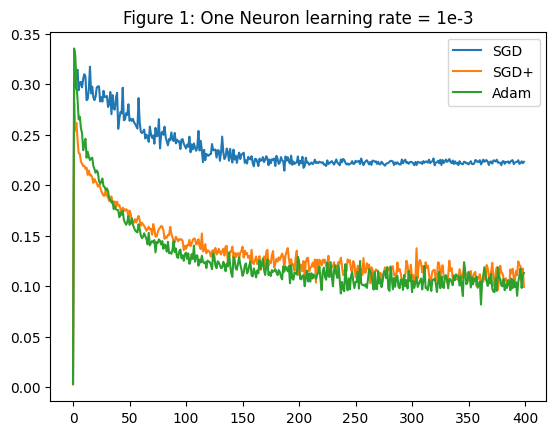

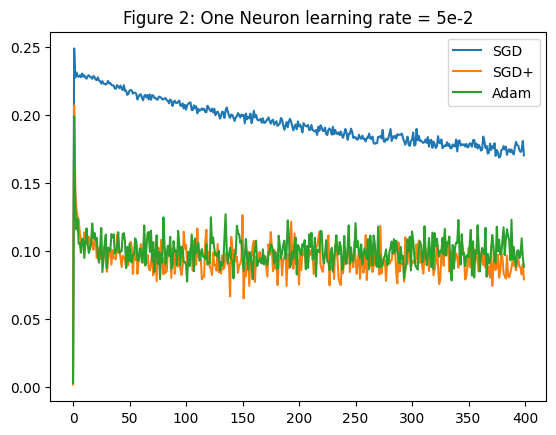

In [3]:
def run_one_nueron_model(model):
    nodisplay(model.parse_expressions)
    training_data = model.gen_training_data()
    loss = collect_loss(model.run_training_loop_one_neuron_model, training_data)
    return loss

def run_different_learning_rates(rate):
    oloss = run_one_nueron_model(ComputationalGraphPrimer(
                                       one_neuron_model = True,
                                       expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
                                       output_vars = ['xw'],
                                       dataset_size = 5000,
                                       learning_rate = rate,
#                                       learning_rate = 5 * 1e-2,
                                       training_iterations = 40000,
                                       batch_size = 8,
                                       display_loss_how_often = 100,
                                       debug = True,))

    ploss = run_one_nueron_model(CGP_SGDPlus(
                                       one_neuron_model = True,
                                       expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
                                       output_vars = ['xw'],
                                       dataset_size = 5000,
                                       learning_rate = rate,
#                                       learning_rate = 5 * 1e-2,
                                       training_iterations = 40000,
                                       batch_size = 8,
                                       display_loss_how_often = 100,
                                       debug = True,))
    
    aloss = run_one_nueron_model(CGP_Adam(
                                       one_neuron_model = True,
                                       expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
                                       output_vars = ['xw'],
                                       dataset_size = 5000,
                                       learning_rate = rate,
#                                       learning_rate = 5 * 1e-2,
                                       training_iterations = 40000,
                                       batch_size = 8,
                                       display_loss_how_often = 100,
                                       debug = True,))
    return oloss, ploss, aloss

oloss, ploss, aloss = run_different_learning_rates(1e-3)
plt.figure()
plt.plot(oloss)
plt.plot(ploss)
plt.plot(aloss)
plt.legend(["SGD","SGD+","Adam"])
plt.title("Figure 1: One Neuron learning rate = 1e-3")
plt.show()

oloss, ploss, aloss = run_different_learning_rates(5e-2)
plt.figure()
plt.plot(oloss)
plt.plot(ploss)
plt.plot(aloss)
plt.legend(["SGD","SGD+","Adam"])
plt.title("Figure 2: One Neuron learning rate = 5e-2")
plt.show()


In [4]:
class CGPMulti_SGDPlus(ComputationalGraphPrimer):
    def parse_multi_layer_expressions(self):
        super().parse_multi_layer_expressions()
        self._prev_grads = {param: 0 for param in self.learnable_params}
        self._prev_bias = [0] * (self.num_layers-1)

    def run_training_loop_multi_neuron_model(self, training_data):

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                


        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_errors, class_labels)      ## BACKPROP loss 
        
    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels):
        gamma = .9
        
        pred_err_backproped_at_layers = {i : [] for i in range(self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [[-2*item] for item in y_error]
        
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            
            vars_in_layer  =  self.layer_vars[back_layer_index]
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]

            layer_params = self.layer_params[back_layer_index]         
            transposed_layer_params = list(zip(*layer_params))
            
            for k in range(len(class_labels)):
                backproped_error = [0] * len(vars_in_next_layer_back)
                for j,var1 in enumerate(vars_in_next_layer_back):
                    for i,var2 in enumerate(vars_in_layer):
                        node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                        node_sig = deriv_sigmoid[k][i]
                        weight = self.vals_for_learnable_params[transposed_layer_params[j][i]]
                        backproped_error[j] += node_err * node_sig * weight
                pred_err_backproped_at_layers[back_layer_index - 1].append(backproped_error)
            
            for i,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][i]
                
                for j,param in enumerate(layer_params):
                    grad = 0
                    for k in range(len(class_labels)):
                        node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                        node_sig = deriv_sigmoid[k][i]
                        grad += node_err * node_sig * input_vals[k][j]
                    grad /= float(len(class_labels))
                    
                    newgrad = self.learning_rate * grad
                    step = gamma * self._prev_grads[param] + newgrad
                    self._prev_grads[param] = step
                    ## Update the learnable parameters
                    self.vals_for_learnable_params[param] -= step
                                    
            bias_grad = 0
            for i,var in enumerate(vars_in_layer):
                for k in range(len(class_labels)):
                    node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                    node_sig = deriv_sigmoid[k][i]
                    bias_grad += node_err * node_sig
            bias_grad /= float(len(class_labels))
            
            new_bias_grad = self.learning_rate * bias_grad
            bias_step = gamma * self._prev_bias[back_layer_index-1] + new_bias_grad
            self._prev_bias[back_layer_index-1] = bias_step
            self.bias[back_layer_index-1] -= bias_step    ## Update the bias
    
class CGPMulti_Adam(CGPMulti_SGDPlus):
    def parse_multi_layer_expressions(self):
        super().parse_multi_layer_expressions()
        self._prev_mom1 = {param: 0 for param in self.learnable_params}
        self._prev_mom2 = {param: 0 for param in self.learnable_params}
        self._prev_mom1_bias = [0] * (self.num_layers-1)
        self._prev_mom2_bias = [0] * (self.num_layers-1)
        
        self.eta = 1e-4
        self.beta1 = .9
        self.beta2 = .99
        
        self.beta1_pow = self.beta1
        self.beta2_pow = self.beta2
        
        
    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels):
        pred_err_backproped_at_layers = {i : [] for i in range(self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [[-2*item] for item in y_error]
        
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            
            vars_in_layer  =  self.layer_vars[back_layer_index]
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]

            layer_params = self.layer_params[back_layer_index]         
            transposed_layer_params = list(zip(*layer_params))
            
            for k in range(len(class_labels)):
                backproped_error = [0] * len(vars_in_next_layer_back)
                for j,var1 in enumerate(vars_in_next_layer_back):
                    for i,var2 in enumerate(vars_in_layer):
                        node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                        node_sig = deriv_sigmoid[k][i]
                        weight = self.vals_for_learnable_params[transposed_layer_params[j][i]]
                        backproped_error[j] += node_err * node_sig * weight
                pred_err_backproped_at_layers[back_layer_index - 1].append(backproped_error)
            
            for i,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][i]
                
                for j,param in enumerate(layer_params):
                    grad = 0
                    for k in range(len(class_labels)):
                        node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                        node_sig = deriv_sigmoid[k][i]
                        grad += node_err * node_sig * input_vals[k][j]
                    grad /= float(len(class_labels))
                    
                    mk = self.beta1 * self._prev_mom1[param] + (1 - self.beta1) * grad
                    self._prev_mom1[param] = mk

                    vk = self.beta2 * self._prev_mom2[param] + (1 - self.beta2) * (grad**2)
                    self._prev_mom2[param] = vk

                    cor_mk = mk / (1 - self.beta1_pow)
                    cor_vk = vk / (1 - self.beta2_pow)

                    step = self.learning_rate / np.sqrt(cor_vk + self.eta) * cor_mk

                    self.vals_for_learnable_params[param] -= step
                                    
            bias_grad = 0
            for i,var in enumerate(vars_in_layer):
                for k in range(len(class_labels)):
                    node_err = pred_err_backproped_at_layers[back_layer_index][k][i]
                    node_sig = deriv_sigmoid[k][i]
                    bias_grad += node_err * node_sig
            bias_grad /= float(len(class_labels))
            
            # new_bias_grad = -2 * y_error * deriv_sigmoid
            mk = self.beta1 * self._prev_mom1_bias[back_layer_index-1] + (1 - self.beta1) * bias_grad
            self._prev_mom1_bias[back_layer_index-1] = mk

            vk = self.beta2 * self._prev_mom2_bias[back_layer_index-1] + (1 - self.beta2) * (bias_grad**2)
            self._prev_mom2_bias[back_layer_index-1] = vk

            cor_mk = mk / (1 - self.beta1_pow)
            cor_vk = vk / (1 - self.beta2_pow)

            bias_step = self.learning_rate / np.sqrt(cor_vk + self.eta) * cor_mk
            self.bias[back_layer_index-1] -= bias_step    ## Update the bias

        self.beta1_pow *= self.beta1
        self.beta2_pow *= self.beta2

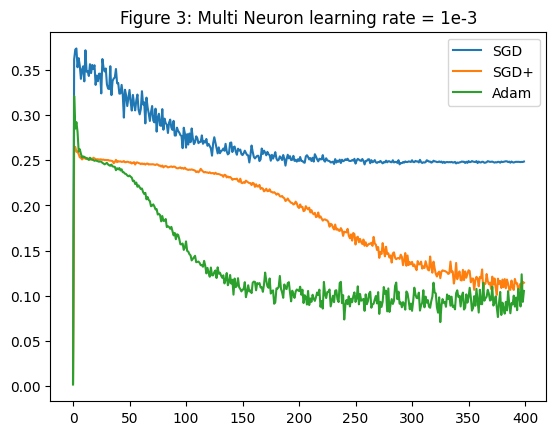

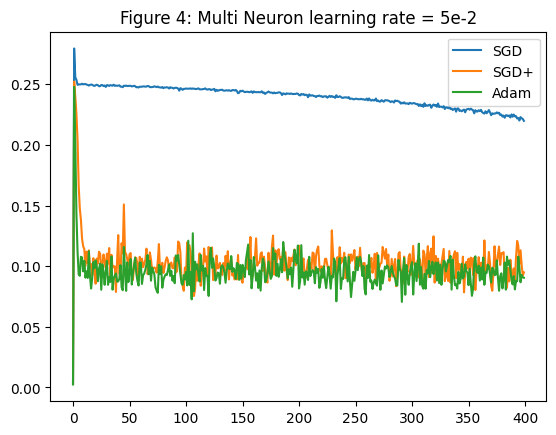

In [5]:
def run_multi_nueron_model(model):
    nodisplay(model.parse_multi_layer_expressions)
    training_data = model.gen_training_data()
    loss = collect_loss(model.run_training_loop_multi_neuron_model, training_data)
    return loss

def run_different_learning_rates_multi(rate):
    oloss = run_multi_nueron_model(ComputationalGraphPrimer(
                                   num_layers = 3,
                                   layers_config = [4,2,1],
                                   expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                                                  'xz=bp*xp+bq*xq+br*xr+bs*xs',
                                                  'xo=cp*xw+cq*xz'],
                                   output_vars = ['xo'],
                                   dataset_size = 5000,
                                   learning_rate = rate,
                                   training_iterations = 40000,
                                   batch_size = 8,
                                   display_loss_how_often = 100,
                                   debug = True))

    ploss = run_multi_nueron_model(CGPMulti_SGDPlus(
                                   num_layers = 3,
                                   layers_config = [4,2,1],
                                   expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                                                  'xz=bp*xp+bq*xq+br*xr+bs*xs',
                                                  'xo=cp*xw+cq*xz'],
                                   output_vars = ['xo'],
                                   dataset_size = 5000,
                                   learning_rate = rate,
                                   training_iterations = 40000,
                                   batch_size = 8,
                                   display_loss_how_often = 100,
                                   debug = True))

    aloss = run_multi_nueron_model(CGPMulti_Adam(
                                   num_layers = 3,
                                   layers_config = [4,2,1],
                                   expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                                                  'xz=bp*xp+bq*xq+br*xr+bs*xs',
                                                  'xo=cp*xw+cq*xz'],
                                   output_vars = ['xo'],
                                   dataset_size = 5000,
                                   learning_rate = rate,
                                   training_iterations = 40000,
                                   batch_size = 8,
                                   display_loss_how_often = 100,
                                   debug = True))
    return oloss, ploss, aloss

oloss, ploss, aloss = run_different_learning_rates_multi(1e-3)
plt.figure()
plt.plot(oloss)
plt.plot(ploss)
plt.plot(aloss)
plt.legend(["SGD","SGD+","Adam"])
plt.title("Figure 3: Multi Neuron learning rate = 1e-3")
plt.show()

oloss, ploss, aloss = run_different_learning_rates_multi(5e-2)
plt.figure()
plt.plot(oloss)
plt.plot(ploss)
plt.plot(aloss)
plt.legend(["SGD","SGD+","Adam"])
plt.title("Figure 4: Multi Neuron learning rate = 5e-2")
plt.show()

## Findings

Adam and SGD+ significantly outperform vanilla SGD, especially in the multi nueron case. Although comparing between Adam and SGD+, they seem to perform similarly, i.e. reach the same loss. However, Adam gets there quicker, the real benefits can obviously be seen in the multi neuron case. In the single neuron case, it hardly makes a difference, but who is using a single nueron network now adays? Also, making the learning rate larger seemed to make convergence reached quicker. I don't know if that's just a fluke of this dataset and network architecture since its just a hyper-parameter that needs to be tuned usually. 

Also, I override the training loop functions to implement SGD correctly. See [https://piazza.com/class/lcl25tn177260u/post/87](https://piazza.com/class/lcl25tn177260u/post/87).